#**Bidirectional LSTM model training and testing**



###Drive preparation section

Mounting google drive to access data on drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Assigning variables to file path

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab_Notebooks/Dissertation' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Data', 'Code']


In [ ]:
DATA_PATH_AFTER_MYDRIVE = 'Colab_Notebooks/Dissertation/Data' 
DATA_PATH = os.path.join('drive', 'My Drive', DATA_PATH_AFTER_MYDRIVE)
print(os.listdir(DATA_PATH))

['Bengaluru_air_met_df.csv', 'Delhi_air_met_df.csv', 'Hyderabad_air_met_df.csv', 'Jaipur_air_met_df.csv', 'Mumbai_air_met_df.csv', 'Saved_Models']


###Packages installation section

Installation of tensorflow package for algorithms.

In [ ]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installation of PerMetrics package for Performance metrics of models

In [ ]:
! pip install permetrics==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Installation of Keras Tuner package for hyperparameter tuning of models.

In [ ]:
! pip install keras-tuner -q

     |████████████████████████████████| 135 kB 15.8 MB/s 
     |████████████████████████████████| 1.6 MB 58.1 MB/s 


Installation of tensorflow addons package for AdamW optimizer.

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.2 MB/s 


###Time series data preparation section

Import of necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from math import sqrt
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from permetrics.regression import RegressionMetric
import keras_tuner
import tensorflow_addons as tfa
import time
import pickle

Seed random generators for consistent results over different runs of the code script.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Load data preprocessed data set of air pollution and meteorological data for Delhi city into a pandas dataframe.

In [ ]:
Delhi_air_met_df = pd.read_csv(os.path.join(DATA_PATH,'Delhi_air_met_df.csv'))

Delete unnecessary columns.

In [ ]:
Delhi_air_met_df.drop(columns=['Unnamed: 0', 'Datetime'], inplace=True)

*Coding reference for above executions:*

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

Splitting data into train and test sets without shuffeling, to preserve the chronology of the time series data.

In [ ]:
train_size = int(len(Delhi_air_met_df) * 0.8)
test_size = len(Delhi_air_met_df) - train_size
train_df, test_df = Delhi_air_met_df.iloc[0:train_size], Delhi_air_met_df.iloc[train_size:len(Delhi_air_met_df)]

*Coding reference for above executions:*

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.youtube.com/watch?v=xaIA83x5Icg

Creation of normalization object.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

Fitting only training data to normalization object.

In [ ]:
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)

Scaling test data with normalization object that has been trained with training data only.

In [ ]:
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

Defining a function to create Rolling Window of time series data.

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Assigning variable to time period/frame of past timestamps, which the models would take as input to predict target value at future timestamp(S).

In [ ]:
time_steps = 24

Obtraining variables and targets for training and test data sets in Rolling Window format unsing above defined function. 

Note that the variables that will be input for the algorithms will be in 3 dimensional array, with a shape as 

(no. of observations, time steps of past, number of variable).

In [ ]:
X_train, y_train = create_dataset(train_df, train_df['PM2.5'], time_steps)
X_test, y_test = create_dataset(test_df, test_df['PM2.5'], time_steps)

*Coding reference for above executions:*

https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.youtube.com/watch?v=xaIA83x5Icg

###Model trainig, testing and tuning section

Creation of early stopping object to stop trainig after no decrease in loss function value after consecutive number of steps assigned to patience argument.

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

*Coding reference for above executions:*

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Creation of baseline model.

In [ ]:
BiLSTM_model0 = keras.Sequential()
BiLSTM_model0.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model0.add(layers.Dense(1))
BiLSTM_model0.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

*Coding reference for above executions:*

https://keras.io/api/layers/recurrent_layers/lstm/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Fitting baseline model to training data.

In [ ]:
BiLSTM0_history = BiLSTM_model0.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 21ms/step - loss: 0.0471 - val_loss: 0.0156
Epoch 2/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0326 - val_loss: 0.0129
Epoch 3/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0316 - val_loss: 0.0122
Epoch 4/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0312 - val_loss: 0.0174
Epoch 5/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0312 - val_loss: 0.0118
Epoch 6/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0307 - val_loss: 0.0120
Epoch 7/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0306 - val_loss: 0.0172
Epoch 8/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0305 - val_loss: 0.0148
Epoch 9/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0305 - val_loss: 0.0115
Epoch 10/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0

Plotting loss curves of trainig and validation sets during the training of the baseline model.

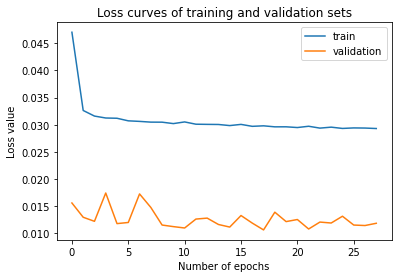

In [ ]:
plt.plot(BiLSTM0_history.history['loss'], label='train')
plt.plot(BiLSTM0_history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss curves of training and validation sets')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.show()

Prediction of target values for test data set variables.

In [ ]:
y_pred0 = BiLSTM_model0.predict(X_test)

Reshaping the array of actual target values of test data set and then applying inverse transformation to get them to original scale before comparison with prediction values.

In [ ]:
y_test_reshaped = y_test.reshape(-1,1)
y_test_inv = np.concatenate((test_df.values[:-24,:-1], y_test_reshaped), axis=1)
y_test_inv = scaler.inverse_transform(y_test_inv)[:,-1]

Defining a function that would apply inverse transform to the predicted values of target for test data set to make them comparable with the actual values of target in the original scale of the data.

In [ ]:
def prediction_invertor(ypredict):
  ypredict_inverse = np.concatenate((test_df.values[:-24,:-1], ypredict), axis=1)
  ypredict_inverse = scaler.inverse_transform(ypredict_inverse)[:,-1]

  return ypredict_inverse;

Obtaining predicted value of test target column in scale of original data.

In [ ]:
y_pred0_inv = prediction_invertor(y_pred0)

Evaluation of baseline model performance in terms of Root Mean Square Error by comparing the actual and predicted values of target column of test data set.

In [ ]:
rmse0 = metrics.mean_squared_error(y_test_inv, y_pred0_inv, squared=False)
print('Test RMSE: %.3f' % rmse0)

Test RMSE: 19.768


*Coding reference for above executions:*

https://keras.io/api/layers/recurrent_layers/lstm/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Creation of small subsets of training data to fit to models for hyperparameter tuning.

In [ ]:
X_grid, y_grid = X_train[:10000], y_train[:10000]

Creation of small subsets of training data to validate models for hyperparameter tuning.

In [ ]:
X_grid_val, y_grid_val = X_train[10000:12000], y_train[10000:12000]

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model1(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(units=hp.Int("units", min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

*Coding reference for above executions:*

https://www.youtube.com/watch?v=Lx16T9cl5ng

https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/api/keras_tuner/tuners/base_tuner/

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner11 = keras_tuner.Hyperband(
    hypermodel=build_model1,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner11.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 12 Complete [00h 00m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 05s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner11.get_best_hyperparameters()[0].values

{'units': 50,
 'learning_rate': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner12 = keras_tuner.BayesianOptimization(
    hypermodel=build_model1,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner12.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 40s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 12m 46s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner12.get_best_hyperparameters()[0].values

{'units': 150, 'learning_rate': 0.0001}

*Coding reference for above executions:*

https://www.youtube.com/watch?v=Lx16T9cl5ng

https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/api/keras_tuner/tuners/base_tuner/

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model11 = keras.Sequential()
BiLSTM_model11.add(layers.Bidirectional(layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model11.add(layers.Dense(1))
BiLSTM_model11.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiLSTM11_history = BiLSTM_model11.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 19s 29ms/step - loss: 0.0465 - val_loss: 0.0253
Epoch 2/100
479/479 [==============================] - 12s 26ms/step - loss: 0.0363 - val_loss: 0.0235
Epoch 3/100
479/479 [==============================] - 12s 26ms/step - loss: 0.0345 - val_loss: 0.0193
Epoch 4/100
479/479 [==============================] - 14s 29ms/step - loss: 0.0335 - val_loss: 0.0194
Epoch 5/100
479/479 [==============================] - 12s 26ms/step - loss: 0.0329 - val_loss: 0.0163
Epoch 6/100
479/479 [==============================] - 14s 29ms/step - loss: 0.0327 - val_loss: 0.0161
Epoch 7/100
479/479 [==============================] - 12s 26ms/step - loss: 0.0323 - val_loss: 0.0157
Epoch 8/100
479/479 [==============================] - 12s 26ms/step - loss: 0.0321 - val_loss: 0.0151
Epoch 9/100
479/479 [==============================] - 12s 26ms/step - loss: 0.0319 - val_loss: 0.0166
Epoch 10/100
479/479 [==============================] - 15s 31ms/step - l

In [ ]:
y_pred11 = BiLSTM_model11.predict(X_test)

In [ ]:
y_pred11_inv = prediction_invertor(y_pred11)

In [ ]:
rmse11 = metrics.mean_squared_error(y_test_inv, y_pred11_inv, squared=False)
print('Test RMSE: %.3f' % rmse11)

Test RMSE: 22.746


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model12 = keras.Sequential()
BiLSTM_model12.add(layers.Bidirectional(layers.LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model12.add(layers.Dense(1))
BiLSTM_model12.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
BiLSTM12_history = BiLSTM_model12.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 55s 106ms/step - loss: 0.0374 - val_loss: 0.0195
Epoch 2/100
479/479 [==============================] - 46s 95ms/step - loss: 0.0335 - val_loss: 0.0171
Epoch 3/100
479/479 [==============================] - 46s 96ms/step - loss: 0.0330 - val_loss: 0.0158
Epoch 4/100
479/479 [==============================] - 46s 96ms/step - loss: 0.0324 - val_loss: 0.0184
Epoch 5/100
479/479 [==============================] - 48s 100ms/step - loss: 0.0322 - val_loss: 0.0142
Epoch 6/100
479/479 [==============================] - 46s 96ms/step - loss: 0.0320 - val_loss: 0.0141
Epoch 7/100
479/479 [==============================] - 46s 96ms/step - loss: 0.0317 - val_loss: 0.0153
Epoch 8/100
479/479 [==============================] - 48s 100ms/step - loss: 0.0315 - val_loss: 0.0178
Epoch 9/100
479/479 [==============================] - 46s 96ms/step - loss: 0.0315 - val_loss: 0.0131
Epoch 10/100
479/479 [==============================] - 46s 96ms/step 

In [ ]:
y_pred12 = BiLSTM_model12.predict(X_test)

In [ ]:
y_pred12_inv = prediction_invertor(y_pred12)

In [ ]:
rmse12 = metrics.mean_squared_error(y_test_inv, y_pred12_inv, squared=False)
print('Test RMSE: %.3f' % rmse12)

Test RMSE: 22.193


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model12(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(units=hp.Int("units", min_value=60, max_value=100, step=10), input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner112 = keras_tuner.Hyperband(
    hypermodel=build_model12,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner112.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 13 Complete [00h 00m 09s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 30s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner112.get_best_hyperparameters()[0].values

{'units': 70,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner122 = keras_tuner.BayesianOptimization(
    hypermodel=build_model12,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner122.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 59s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 10m 51s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner122.get_best_hyperparameters()[0].values

{'units': 80, 'learning_rate': 0.01}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model13 = keras.Sequential()
BiLSTM_model13.add(layers.Bidirectional(layers.LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model13.add(layers.Dense(1))
BiLSTM_model13.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [ ]:
BiLSTM13_history = BiLSTM_model13.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 22s 37ms/step - loss: 0.0371 - val_loss: 0.0196
Epoch 2/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0329 - val_loss: 0.0204
Epoch 3/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0325 - val_loss: 0.0180
Epoch 4/100
479/479 [==============================] - 17s 35ms/step - loss: 0.0315 - val_loss: 0.0127
Epoch 5/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0315 - val_loss: 0.0128
Epoch 6/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0317 - val_loss: 0.0141
Epoch 7/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0312 - val_loss: 0.0162
Epoch 8/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0310 - val_loss: 0.0137
Epoch 9/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0310 - val_loss: 0.0113
Epoch 10/100
479/479 [==============================] - 16s 33ms/step - l

In [ ]:
y_pred13 = BiLSTM_model13.predict(X_test)

In [ ]:
y_pred13_inv = prediction_invertor(y_pred13)

In [ ]:
rmse13 = metrics.mean_squared_error(y_test_inv, y_pred13_inv, squared=False)
print('Test RMSE: %.3f' % rmse13)

Test RMSE: 22.099


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model14 = keras.Sequential()
BiLSTM_model14.add(layers.Bidirectional(layers.LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model14.add(layers.Dense(1))
BiLSTM_model14.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM14_history = BiLSTM_model14.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 23s 39ms/step - loss: 0.0464 - val_loss: 0.0156
Epoch 2/100
479/479 [==============================] - 21s 44ms/step - loss: 0.0324 - val_loss: 0.0127
Epoch 3/100
479/479 [==============================] - 21s 43ms/step - loss: 0.0315 - val_loss: 0.0121
Epoch 4/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0312 - val_loss: 0.0187
Epoch 5/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0312 - val_loss: 0.0138
Epoch 6/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0308 - val_loss: 0.0130
Epoch 7/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0306 - val_loss: 0.0127
Epoch 8/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0305 - val_loss: 0.0146
Epoch 9/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0306 - val_loss: 0.0126
Epoch 10/100
479/479 [==============================] - 18s 37ms/step - l

In [ ]:
y_pred14 = BiLSTM_model14.predict(X_test)

In [ ]:
y_pred14_inv = prediction_invertor(y_pred14)

In [ ]:
rmse14 = metrics.mean_squared_error(y_test_inv, y_pred14_inv, squared=False)
print('Test RMSE: %.3f' % rmse14)

Test RMSE: 20.668


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model13(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(units=hp.Int("units", min_value=60, max_value=80, step=5), input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner113 = keras_tuner.Hyperband(
    hypermodel=build_model13,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner113.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 34s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner113.get_best_hyperparameters()[0].values

{'units': 75,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner123 = keras_tuner.BayesianOptimization(
    hypermodel=build_model13,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner123.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 01m 26s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 07m 54s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner123.get_best_hyperparameters()[0].values

{'units': 70, 'learning_rate': 0.001}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model15 = keras.Sequential()
BiLSTM_model15.add(layers.Bidirectional(layers.LSTM(75, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model15.add(layers.Dense(1))
BiLSTM_model15.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM15_history = BiLSTM_model15.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 23s 38ms/step - loss: 0.0490 - val_loss: 0.0150
Epoch 2/100
479/479 [==============================] - 20s 41ms/step - loss: 0.0324 - val_loss: 0.0171
Epoch 3/100
479/479 [==============================] - 19s 41ms/step - loss: 0.0316 - val_loss: 0.0122
Epoch 4/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0313 - val_loss: 0.0153
Epoch 5/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0312 - val_loss: 0.0132
Epoch 6/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0309 - val_loss: 0.0115
Epoch 7/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0306 - val_loss: 0.0160
Epoch 8/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0305 - val_loss: 0.0128
Epoch 9/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0304 - val_loss: 0.0108
Epoch 10/100
479/479 [==============================] - 20s 41ms/step - l

In [ ]:
y_pred15 = BiLSTM_model15.predict(X_test)

In [ ]:
y_pred15_inv = prediction_invertor(y_pred15)

In [ ]:
rmse15 = metrics.mean_squared_error(y_test_inv, y_pred15_inv, squared=False)
print('Test RMSE: %.3f' % rmse15)

Test RMSE: 20.938


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model16 = keras.Sequential()
BiLSTM_model16.add(layers.Bidirectional(layers.LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model16.add(layers.Dense(1))
BiLSTM_model16.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM16_history = BiLSTM_model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 22s 36ms/step - loss: 0.0451 - val_loss: 0.0172
Epoch 2/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0324 - val_loss: 0.0135
Epoch 3/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0316 - val_loss: 0.0120
Epoch 4/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0313 - val_loss: 0.0146
Epoch 5/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0311 - val_loss: 0.0135
Epoch 6/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0308 - val_loss: 0.0117
Epoch 7/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0306 - val_loss: 0.0175
Epoch 8/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0304 - val_loss: 0.0127
Epoch 9/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0305 - val_loss: 0.0113
Epoch 10/100
479/479 [==============================] - 16s 34ms/step - l

In [ ]:
y_pred16 = BiLSTM_model16.predict(X_test)

In [ ]:
y_pred16_inv = prediction_invertor(y_pred16)

In [ ]:
rmse16 = metrics.mean_squared_error(y_test_inv, y_pred16_inv, squared=False)
print('Test RMSE: %.3f' % rmse16)

Test RMSE: 23.182


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons, hidden layers and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model2(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(units=hp.Int(f"input_units", min_value=40, max_value=70, step=10), return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))))

  for i in range(hp.Int("num_layers", 1,3)):
    model.add(layers.Bidirectional(layers.LSTM(units=hp.Int(f"units_{i}", min_value=40, max_value=70, step=10), return_sequences=True)))
  
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner21 = keras_tuner.Hyperband(
    hypermodel=build_model2,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner21.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 186 Complete [00h 02m 15s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 02h 34m 17s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner21.get_best_hyperparameters()[0].values

{'input_units': 70,
 'num_layers': 1,
 'units_0': 60,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner22 = keras_tuner.BayesianOptimization(
    hypermodel=build_model2,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner22.search(X_grid, y_grid, epochs=30, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 01m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 21m 00s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner22.get_best_hyperparameters()[0].values

{'input_units': 50,
 'num_layers': 2,
 'units_0': 70,
 'learning_rate': 0.001,
 'units_1': 40}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model21 = keras.Sequential()
BiLSTM_model21.add(layers.Bidirectional(layers.LSTM(70, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model21.add(layers.Bidirectional(layers.LSTM(60)))
BiLSTM_model21.add(layers.Dense(1))
BiLSTM_model21.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM21_history = BiLSTM_model21.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 50s 86ms/step - loss: 0.0479 - val_loss: 0.0135
Epoch 2/100
479/479 [==============================] - 40s 84ms/step - loss: 0.0325 - val_loss: 0.0125
Epoch 3/100
479/479 [==============================] - 37s 78ms/step - loss: 0.0315 - val_loss: 0.0128
Epoch 4/100
479/479 [==============================] - 40s 83ms/step - loss: 0.0313 - val_loss: 0.0176
Epoch 5/100
479/479 [==============================] - 37s 78ms/step - loss: 0.0314 - val_loss: 0.0165
Epoch 6/100
479/479 [==============================] - 38s 78ms/step - loss: 0.0309 - val_loss: 0.0142
Epoch 7/100
479/479 [==============================] - 40s 83ms/step - loss: 0.0306 - val_loss: 0.0126
Epoch 8/100
479/479 [==============================] - 38s 79ms/step - loss: 0.0306 - val_loss: 0.0176
Epoch 9/100
479/479 [==============================] - 38s 79ms/step - loss: 0.0306 - val_loss: 0.0122
Epoch 10/100
479/479 [==============================] - 40s 83ms/step - l

In [ ]:
y_pred21 = BiLSTM_model21.predict(X_test)

In [ ]:
y_pred21_inv = prediction_invertor(y_pred21)

In [ ]:
rmse21 = metrics.mean_squared_error(y_test_inv, y_pred21_inv, squared=False)
print('Test RMSE: %.3f' % rmse21)

Test RMSE: 23.928


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model22 = keras.Sequential()
BiLSTM_model22.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model22.add(layers.Bidirectional(layers.LSTM(70, return_sequences=True)))
BiLSTM_model22.add(layers.Bidirectional(layers.LSTM(40)))
BiLSTM_model22.add(layers.Dense(1))
BiLSTM_model22.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [ ]:
BiLSTM22_history = BiLSTM_model22.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 83s 138ms/step - loss: 0.0389 - val_loss: 0.0201
Epoch 2/100
479/479 [==============================] - 64s 134ms/step - loss: 0.0333 - val_loss: 0.0154
Epoch 3/100
479/479 [==============================] - 62s 130ms/step - loss: 0.0321 - val_loss: 0.0137
Epoch 4/100
479/479 [==============================] - 62s 130ms/step - loss: 0.0317 - val_loss: 0.0174
Epoch 5/100
479/479 [==============================] - 63s 133ms/step - loss: 0.0315 - val_loss: 0.0163
Epoch 6/100
479/479 [==============================] - 61s 127ms/step - loss: 0.0312 - val_loss: 0.0122
Epoch 7/100
479/479 [==============================] - 61s 128ms/step - loss: 0.0310 - val_loss: 0.0120
Epoch 8/100
479/479 [==============================] - 63s 131ms/step - loss: 0.0309 - val_loss: 0.0122
Epoch 9/100
479/479 [==============================] - 61s 128ms/step - loss: 0.0308 - val_loss: 0.0153
Epoch 10/100
479/479 [==============================] - 63s 132m

In [ ]:
y_pred22 = BiLSTM_model22.predict(X_test)

In [ ]:
y_pred22_inv = prediction_invertor(y_pred22)

In [ ]:
rmse22 = metrics.mean_squared_error(y_test_inv, y_pred22_inv, squared=False)
print('Test RMSE: %.3f' % rmse22)

Test RMSE: 22.960


Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal values of neurons and optimizer learning rate.

In [ ]:
from sklearn import metrics
def build_model21(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(units=hp.Int(f"input_units", min_value=40, max_value=65, step=5), return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Bidirectional(layers.LSTM(units=hp.Int(f"units_1", min_value=40, max_value=65, step=5))))
  model.add(layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner212 = keras_tuner.Hyperband(
    hypermodel=build_model21,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner212.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 186 Complete [00h 02m 10s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 01h 56m 52s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner212.get_best_hyperparameters()[0].values

{'input_units': 50,
 'units_1': 60,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner222 = keras_tuner.BayesianOptimization(
    hypermodel=build_model21,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner222.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 10 Complete [00h 03m 00s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 22m 12s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner222.get_best_hyperparameters()[0].values

{'input_units': 50, 'units_1': 45, 'learning_rate': 0.01}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model23 = keras.Sequential()
BiLSTM_model23.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model23.add(layers.Bidirectional(layers.LSTM(60)))
BiLSTM_model23.add(layers.Dense(1))
BiLSTM_model23.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.001))

In [ ]:
BiLSTM23_history = BiLSTM_model23.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 26s 41ms/step - loss: 0.0378 - val_loss: 0.0155
Epoch 2/100
479/479 [==============================] - 19s 39ms/step - loss: 0.0330 - val_loss: 0.0141
Epoch 3/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0318 - val_loss: 0.0141
Epoch 4/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0315 - val_loss: 0.0159
Epoch 5/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0314 - val_loss: 0.0144
Epoch 6/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0311 - val_loss: 0.0129
Epoch 7/100
479/479 [==============================] - 19s 40ms/step - loss: 0.0309 - val_loss: 0.0117
Epoch 8/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0308 - val_loss: 0.0128
Epoch 9/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0307 - val_loss: 0.0140
Epoch 10/100
479/479 [==============================] - 18s 38ms/step - l

In [ ]:
y_pred23 = BiLSTM_model23.predict(X_test)

In [ ]:
y_pred23_inv = prediction_invertor(y_pred23)

In [ ]:
rmse23 = metrics.mean_squared_error(y_test_inv, y_pred23_inv, squared=False)
print('Test RMSE: %.3f' % rmse23)

Test RMSE: 21.609


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model24 = keras.Sequential()
BiLSTM_model24.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model24.add(layers.Bidirectional(layers.LSTM(45)))
BiLSTM_model24.add(layers.Dense(1))
BiLSTM_model24.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM24_history = BiLSTM_model24.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 25s 39ms/step - loss: 0.0476 - val_loss: 0.0209
Epoch 2/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0323 - val_loss: 0.0122
Epoch 3/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0316 - val_loss: 0.0132
Epoch 4/100
479/479 [==============================] - 17s 36ms/step - loss: 0.0311 - val_loss: 0.0149
Epoch 5/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0313 - val_loss: 0.0148
Epoch 6/100
479/479 [==============================] - 17s 34ms/step - loss: 0.0309 - val_loss: 0.0117
Epoch 7/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0307 - val_loss: 0.0143
Epoch 8/100
479/479 [==============================] - 17s 35ms/step - loss: 0.0305 - val_loss: 0.0146
Epoch 9/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0307 - val_loss: 0.0135
Epoch 10/100
479/479 [==============================] - 17s 34ms/step - l

In [ ]:
y_pred24 = BiLSTM_model24.predict(X_test)

In [ ]:
y_pred24_inv = prediction_invertor(y_pred24)

In [ ]:
rmse24 = metrics.mean_squared_error(y_test_inv, y_pred24_inv, squared=False)
print('Test RMSE: %.3f' % rmse24)

Test RMSE: 20.837


*After all the above iterations, clearly single layer with 64 neurons and optimizer learning rate of 0.01 produced better model performance than other configurations. Hence, this configuration will be considered for the best model.*

Creating, training and testing model with a different activation function.

In [ ]:
BiLSTM_model17 = keras.Sequential()
BiLSTM_model17.add(layers.Bidirectional(layers.LSTM(64, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model17.add(layers.Dense(1))
BiLSTM_model17.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM17_history = BiLSTM_model17.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 10s 18ms/step - loss: 0.0545 - val_loss: 0.0200
Epoch 2/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0371 - val_loss: 0.0223
Epoch 3/100
479/479 [==============================] - 11s 22ms/step - loss: 0.0346 - val_loss: 0.0126
Epoch 4/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0341 - val_loss: 0.0148
Epoch 5/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0332 - val_loss: 0.0146
Epoch 6/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0327 - val_loss: 0.0141
Epoch 7/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0323 - val_loss: 0.0125
Epoch 8/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0322 - val_loss: 0.0123
Epoch 9/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0322 - val_loss: 0.0121
Epoch 10/100
479/479 [==============================] - 8s 17ms/step - loss: 0.0

In [ ]:
y_pred17 = BiLSTM_model17.predict(X_test)

In [ ]:
y_pred17_inv = prediction_invertor(y_pred17)

In [ ]:
rmse17 = metrics.mean_squared_error(y_test_inv, y_pred17_inv, squared=False)
print('Test RMSE: %.3f' % rmse17)

Test RMSE: 22.019


Creating, training and testing model with a different activation function.

In [ ]:
BiLSTM_model18 = keras.Sequential()
BiLSTM_model18.add(layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
BiLSTM_model18.add(layers.Dense(1))
BiLSTM_model18.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
LSTM18_history = BiLSTM_model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 7s 12ms/step - loss: 0.0382 - val_loss: 0.0140
Epoch 2/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0324 - val_loss: 0.0164
Epoch 3/100
479/479 [==============================] - 6s 12ms/step - loss: 0.0319 - val_loss: 0.0122
Epoch 4/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0314 - val_loss: 0.0208
Epoch 5/100
479/479 [==============================] - 6s 13ms/step - loss: 0.0314 - val_loss: 0.0133
Epoch 6/100
479/479 [==============================] - 6s 11ms/step - loss: 0.0310 - val_loss: 0.0133
Epoch 7/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0306 - val_loss: 0.0125
Epoch 8/100
479/479 [==============================] - 5s 11ms/step - loss: 0.0305 - val_loss: 0.0115
Epoch 9/100
479/479 [==============================] - 6s 13ms/step - loss: 0.0304 - val_loss: 0.0125
Epoch 10/100
479/479 [==============================] - 5s 11ms/step - loss: 0.030

In [ ]:
y_pred18 = BiLSTM_model18.predict(X_test)

In [ ]:
y_pred18_inv = prediction_invertor(y_pred18)

In [ ]:
rmse18 = metrics.mean_squared_error(y_test_inv, y_pred18_inv, squared=False)
print('Test RMSE: %.3f' % rmse18)

Test RMSE: 24.265


*It can be seen that the deafault activation function "tanh" gave better performance than the other activation functions. Hence, it will be used in the best model.*

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal dropout value that would regularize the model reducing the chances of overfitting.

In [ ]:
from sklearn import metrics
def build_model3(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.9,step=0.1)))
  model.add(layers.Dense(1))
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner31 = keras_tuner.Hyperband(
    hypermodel=build_model3,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner31.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 00m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 47s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner31.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.5,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner32 = keras_tuner.BayesianOptimization(
    hypermodel=build_model3,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner32.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 9 Complete [00h 00m 37s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 10m 46s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner32.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.1}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model31 = keras.Sequential()
BiLSTM_model31.add(layers.Bidirectional(layers.LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model31.add(layers.Dropout(0.5))
BiLSTM_model31.add(layers.Dense(1))
BiLSTM_model31.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM31_history = BiLSTM_model31.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 13s 21ms/step - loss: 0.0471 - val_loss: 0.0166
Epoch 2/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0341 - val_loss: 0.0147
Epoch 3/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0334 - val_loss: 0.0153
Epoch 4/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0333 - val_loss: 0.0152
Epoch 5/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0330 - val_loss: 0.0208
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0327 - val_loss: 0.0138
Epoch 7/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0326 - val_loss: 0.0185
Epoch 8/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0327 - val_loss: 0.0159
Epoch 9/100
479/479 [==============================] - 9s 19ms/step - loss: 0.0323 - val_loss: 0.0149
Epoch 10/100
479/479 [==============================] - 9s 19ms/step - loss: 0

In [ ]:
y_pred31 = BiLSTM_model31.predict(X_test)

In [ ]:
y_pred31_inv = prediction_invertor(y_pred31)

In [ ]:
rmse31 = metrics.mean_squared_error(y_test_inv, y_pred31_inv, squared=False)
print('Test RMSE: %.3f' % rmse31)

Test RMSE: 24.130


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model32 = keras.Sequential()
BiLSTM_model32.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model32.add(layers.Dropout(0.1))
BiLSTM_model32.add(layers.Dense(1))
BiLSTM_model32.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(0.01))

In [ ]:
BiLSTM32_history = BiLSTM_model32.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 12s 19ms/step - loss: 0.0494 - val_loss: 0.0141
Epoch 2/100
479/479 [==============================] - 10s 20ms/step - loss: 0.0328 - val_loss: 0.0154
Epoch 3/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0320 - val_loss: 0.0148
Epoch 4/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0317 - val_loss: 0.0140
Epoch 5/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0316 - val_loss: 0.0117
Epoch 6/100
479/479 [==============================] - 10s 21ms/step - loss: 0.0312 - val_loss: 0.0127
Epoch 7/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0312 - val_loss: 0.0145
Epoch 8/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0312 - val_loss: 0.0117
Epoch 9/100
479/479 [==============================] - 9s 18ms/step - loss: 0.0311 - val_loss: 0.0133
Epoch 10/100
479/479 [==============================] - 9s 18ms/step - loss: 0.

In [ ]:
y_pred32 = BiLSTM_model32.predict(X_test)

In [ ]:
y_pred32_inv = prediction_invertor(y_pred32)

In [ ]:
rmse32 = metrics.mean_squared_error(y_test_inv, y_pred32_inv, squared=False)
print('Test RMSE: %.3f' % rmse32)

Test RMSE: 23.471


*To strike a balance between model performance and model regularization dropout value of 0.1 will be considered for best model.*

Defining a function to be used in keras tuners for hyperparameter tuning to determine optimal value of weight decay that would further reduce the possibility of model overfitting.

In [ ]:
from sklearn import metrics
def build_model4(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(1))
  hp_weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4, 1e-5])
  model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=hp_weight_decay, learning_rate=0.01), metrics=['accuracy'])
  
  return model

Creation of Hyperband tuner object for hyperparameter tuning.

In [ ]:
tuner41 = keras_tuner.Hyperband(
    hypermodel=build_model4,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    )

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner41.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 4 Complete [00h 00m 08s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 40s


Best hyperparameters obtained using Hyperband tuner.

In [ ]:
tuner41.get_best_hyperparameters()[0].values

{'weight_decay': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 5,
 'tuner/round': 0}

Creation of Bayesian Optimization tuner object for hyperparameter tuning.

In [ ]:
tuner42 = keras_tuner.BayesianOptimization(
    hypermodel=build_model4,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    directory="my_dir",
    project_name="BLR_BiLSTM",
)

Fitting and validating hyperparameters in tuning with Hyperband tuner, on subsets of training data created above.

In [ ]:
tuner42.search(X_grid, y_grid, epochs=50, validation_data=(X_grid_val, y_grid_val), callbacks=[early_stopping_monitor])

Trial 4 Complete [00h 01m 17s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 05m 10s


Best hyperparameters obtained using Bayesian Optimization tuner.

In [ ]:
tuner42.get_best_hyperparameters()[0].values

{'weight_decay': 0.0001}

Creating, training and testing models with best hyperparameters obtained from Hyperband tuner.

In [ ]:
BiLSTM_model41 = keras.Sequential()
BiLSTM_model41.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model41.add(layers.Dropout(0.1))
BiLSTM_model41.add(layers.Dense(1))
BiLSTM_model41.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.01, learning_rate=0.01))

In [ ]:
BiLSTM41_history = BiLSTM_model41.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 32s 44ms/step - loss: 0.0485 - val_loss: 0.0189
Epoch 2/100
479/479 [==============================] - 18s 39ms/step - loss: 0.0359 - val_loss: 0.0327
Epoch 3/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0364 - val_loss: 0.0181
Epoch 4/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0362 - val_loss: 0.0236
Epoch 5/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0363 - val_loss: 0.0364
Epoch 6/100
479/479 [==============================] - 18s 37ms/step - loss: 0.0362 - val_loss: 0.0343
Epoch 7/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0359 - val_loss: 0.0259
Epoch 8/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0362 - val_loss: 0.0242
Epoch 9/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0361 - val_loss: 0.0222
Epoch 10/100
479/479 [==============================] - 18s 38ms/step - l

In [ ]:
y_pred41 = BiLSTM_model41.predict(X_test)

In [ ]:
y_pred41_inv = prediction_invertor(y_pred41)

In [ ]:
rmse41 = metrics.mean_squared_error(y_test_inv, y_pred41_inv, squared=False)
print('Test RMSE: %.3f' % rmse41)

Test RMSE: 34.230


Creating, training and testing models with best hyperparameters obtained from Bayesian Optimization tuner.

In [ ]:
BiLSTM_model42 = keras.Sequential()
BiLSTM_model42.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model42.add(layers.Dropout(0.1))
BiLSTM_model42.add(layers.Dense(1))
BiLSTM_model42.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

In [ ]:
BiLSTM42_history = BiLSTM_model42.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
479/479 [==============================] - 22s 35ms/step - loss: 0.0493 - val_loss: 0.0153
Epoch 2/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0329 - val_loss: 0.0153
Epoch 3/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0321 - val_loss: 0.0136
Epoch 4/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0317 - val_loss: 0.0141
Epoch 5/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0318 - val_loss: 0.0143
Epoch 6/100
479/479 [==============================] - 16s 34ms/step - loss: 0.0314 - val_loss: 0.0125
Epoch 7/100
479/479 [==============================] - 18s 38ms/step - loss: 0.0313 - val_loss: 0.0141
Epoch 8/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0313 - val_loss: 0.0168
Epoch 9/100
479/479 [==============================] - 16s 33ms/step - loss: 0.0315 - val_loss: 0.0138
Epoch 10/100
479/479 [==============================] - 16s 33ms/step - l

In [ ]:
y_pred42 = BiLSTM_model42.predict(X_test)

In [ ]:
y_pred42_inv = prediction_invertor(y_pred42)

In [ ]:
rmse42 = metrics.mean_squared_error(y_test_inv, y_pred42_inv, squared=False)
print('Test RMSE: %.3f' % rmse42)

Test RMSE: 22.975


*To strike a balance between model performance and model regularization weight decay value of 0.0001 will be considered for best model.*

Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 32.

In [ ]:
BiLSTM_model51 = keras.Sequential()
BiLSTM_model51.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model51.add(layers.Dropout(0.1))
BiLSTM_model51.add(layers.Dense(1))
BiLSTM_model51.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

In [ ]:
BiLSTM51_history = BiLSTM_model51.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
958/958 [==============================] - 32s 28ms/step - loss: 0.0413 - val_loss: 0.0136
Epoch 2/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0329 - val_loss: 0.0231
Epoch 3/100
958/958 [==============================] - 23s 24ms/step - loss: 0.0325 - val_loss: 0.0149
Epoch 4/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0323 - val_loss: 0.0160
Epoch 5/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0322 - val_loss: 0.0142
Epoch 6/100
958/958 [==============================] - 25s 26ms/step - loss: 0.0319 - val_loss: 0.0134
Epoch 7/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0315 - val_loss: 0.0146
Epoch 8/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0317 - val_loss: 0.0173
Epoch 9/100
958/958 [==============================] - 22s 23ms/step - loss: 0.0317 - val_loss: 0.0141
Epoch 10/100
958/958 [==============================] - 22s 23ms/step - l

In [ ]:
y_pred51 = BiLSTM_model51.predict(X_test)

In [ ]:
y_pred51_inv = prediction_invertor(y_pred51)

In [ ]:
rmse51 = metrics.mean_squared_error(y_test_inv, y_pred51_inv, squared=False)
print('Test RMSE: %.3f' % rmse51)

Test RMSE: 24.892


Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 128.

In [ ]:
BiLSTM_model52 = keras.Sequential()
BiLSTM_model52.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model52.add(layers.Dropout(0.1))
BiLSTM_model52.add(layers.Dense(1))
BiLSTM_model52.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

In [ ]:
BiLSTM52_history = BiLSTM_model52.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
240/240 [==============================] - 16s 49ms/step - loss: 0.0659 - val_loss: 0.0192
Epoch 2/100
240/240 [==============================] - 13s 55ms/step - loss: 0.0331 - val_loss: 0.0182
Epoch 3/100
240/240 [==============================] - 11s 45ms/step - loss: 0.0323 - val_loss: 0.0159
Epoch 4/100
240/240 [==============================] - 11s 45ms/step - loss: 0.0319 - val_loss: 0.0139
Epoch 5/100
240/240 [==============================] - 11s 45ms/step - loss: 0.0314 - val_loss: 0.0134
Epoch 6/100
240/240 [==============================] - 11s 45ms/step - loss: 0.0313 - val_loss: 0.0131
Epoch 7/100
240/240 [==============================] - 11s 46ms/step - loss: 0.0312 - val_loss: 0.0150
Epoch 8/100
240/240 [==============================] - 11s 45ms/step - loss: 0.0315 - val_loss: 0.0132
Epoch 9/100
240/240 [==============================] - 11s 45ms/step - loss: 0.0310 - val_loss: 0.0146
Epoch 10/100
240/240 [==============================] - 11s 45ms/step - l

In [ ]:
y_pred52 = BiLSTM_model52.predict(X_test)

In [ ]:
y_pred52_inv = prediction_invertor(y_pred52)

In [ ]:
rmse52 = metrics.mean_squared_error(y_test_inv, y_pred52_inv, squared=False)
print('Test RMSE: %.3f' % rmse52)

Test RMSE: 24.986


Checking the changes in performance of model with all optimal hyperparameters, for a batch sizes of 192.

In [ ]:
BiLSTM_model53 = keras.Sequential()
BiLSTM_model53.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
BiLSTM_model53.add(layers.Dropout(0.1))
BiLSTM_model53.add(layers.Dense(1))
BiLSTM_model53.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

In [ ]:
BiLSTM53_history = BiLSTM_model53.fit(X_train, y_train, epochs=100, batch_size=192, validation_split=0.125, callbacks=[early_stopping_monitor])

Epoch 1/100
160/160 [==============================] - 17s 83ms/step - loss: 0.0705 - val_loss: 0.0200
Epoch 2/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0333 - val_loss: 0.0156
Epoch 3/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0321 - val_loss: 0.0145
Epoch 4/100
160/160 [==============================] - 12s 75ms/step - loss: 0.0318 - val_loss: 0.0129
Epoch 5/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0318 - val_loss: 0.0149
Epoch 6/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0315 - val_loss: 0.0130
Epoch 7/100
160/160 [==============================] - 15s 91ms/step - loss: 0.0311 - val_loss: 0.0118
Epoch 8/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0311 - val_loss: 0.0136
Epoch 9/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0310 - val_loss: 0.0114
Epoch 10/100
160/160 [==============================] - 12s 75ms/step - l

In [ ]:
y_pred53 = BiLSTM_model53.predict(X_test)

In [ ]:
y_pred53_inv = prediction_invertor(y_pred53)

In [ ]:
rmse53 = metrics.mean_squared_error(y_test_inv, y_pred53_inv, squared=False)
print('Test RMSE: %.3f' % rmse53)

Test RMSE: 20.965


*From above iterations it can be observed that a batch size of 192 gave better performance than other sizes for the model training. Hence, the best model will be trained with this batch size.*

Creating, training and testing best model with all optimal hyperparameters and batch size.

In [ ]:
Best_BiLSTM_model = keras.Sequential()
Best_BiLSTM_model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))))
Best_BiLSTM_model.add(layers.Dropout(0.1))
Best_BiLSTM_model.add(layers.Dense(1))
Best_BiLSTM_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

In [ ]:
LSTM_start_time = time.time()
Best_BiLSTM_history = Best_BiLSTM_model.fit(X_train, y_train, epochs=100, batch_size=192, validation_split=0.125, callbacks=[early_stopping_monitor])
LSTM_end_time = time.time()

Epoch 1/100
160/160 [==============================] - 18s 83ms/step - loss: 0.0695 - val_loss: 0.0163
Epoch 2/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0330 - val_loss: 0.0142
Epoch 3/100
160/160 [==============================] - 14s 85ms/step - loss: 0.0320 - val_loss: 0.0129
Epoch 4/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0320 - val_loss: 0.0117
Epoch 5/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0318 - val_loss: 0.0150
Epoch 6/100
160/160 [==============================] - 13s 80ms/step - loss: 0.0312 - val_loss: 0.0113
Epoch 7/100
160/160 [==============================] - 14s 87ms/step - loss: 0.0314 - val_loss: 0.0144
Epoch 8/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0312 - val_loss: 0.0167
Epoch 9/100
160/160 [==============================] - 12s 75ms/step - loss: 0.0308 - val_loss: 0.0112
Epoch 10/100
160/160 [==============================] - 12s 76ms/step - l

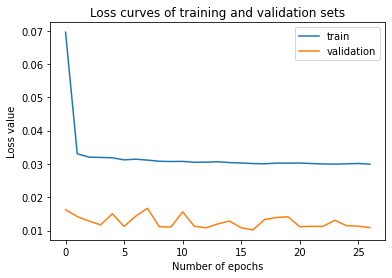

In [ ]:
plt.plot(Best_BiLSTM_history.history['loss'], label='train')
plt.plot(Best_BiLSTM_history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss curves of training and validation sets')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.show()

Evaluating time taken for training by the best model.

In [ ]:
BiLSTM_training_time = LSTM_end_time - LSTM_start_time
BiLSTM_training_time

344.2421004772186

In [ ]:
y_pred_bilstm = Best_BiLSTM_model.predict(X_test)

In [ ]:
y_pred_bilstm_inv = prediction_invertor(y_pred_bilstm)

In [ ]:
rmse_bilstm = metrics.mean_squared_error(y_test_inv, y_pred_bilstm_inv, squared=False)
print('Test RMSE: %.3f' % rmse_bilstm)

Test RMSE: 21.836


Evaluating the best model in terms of Mean Absolute Error.

In [ ]:
mae_br = metrics.mean_absolute_error(y_test_inv, y_pred_bilstm_inv)
print('Test MAE: %.3f' % mae_br)

Test MAE: 13.183


Evaluating the best model in terms of R2 (R square) score.

In [ ]:
r2_br = metrics.r2_score(y_test_inv, y_pred_bilstm_inv)
print('Test R2: %.3f' % r2_br)

Test R2: 0.945


Creating metric object of permetric library that would produce different evaluation metrics.

In [ ]:
evaluator0 = RegressionMetric(y_test_inv, y_pred_bilstm_inv, decimal=3)

Evaluating the best model in terms of Nash-Sutcliffe Efficiency Coefficient.

In [ ]:
print('Test NSE: %.3f' % evaluator0.NSE())

Test NSE: 0.945


Evaluating the best model in terms of Coefficient of Determination.

In [ ]:
print('Test CC: %.3f' % evaluator0.coefficient_of_determination())

Test CC: 0.945


*Coding reference for above executions:*

https://scikit-learn.org/stable/modules/model_evaluation.html

https://pypi.org/project/permetrics/

Saving best model in the TensorFlow SavedModel format that saves model architecture, weights, optimizer and losses of the trained best model, to enable transfer learning.

In [ ]:
# tf.keras.models.save_model(Best_BiLSTM_model, os.path.join(DATA_PATH,'Saved_Models/BiLSTM'))

*Coding reference for above executions:*

https://www.tensorflow.org/guide/keras/save_and_serialize

Creating list of other cities in the study, the data of which will be used to train and test the best model, with transfer learning as well as without transfer learning.

In [ ]:
other_cities_list = ['Bengaluru', 'Hyderabad', 'Jaipur', 'Mumbai']

Load data preprocessed data set of air pollution and meteorological data for other cities into a pandas dataframes.

In [ ]:
for city in other_cities_list:
  globals()[f"{city}_air_met_df"] = pd.read_csv(os.path.join(DATA_PATH,'{}_air_met_df.csv'.format(city)))

Randomly checking if the datarames are created.

In [ ]:
Hyderabad_air_met_df.head()

,Unnamed: 0,Datetime,sunHour,uvIndex.1,DewPointC,HeatIndexC,cloudcover,humidity,precipMM,pressure,...,windspeedKmph,CO,NH3,NO,NO2,NOx,O3,PM10,PM2.5,SO2
0,0,2015-01-04 14:00:00,8.7,7,15,27,40,48,0.0,1013,...,13,0.24,39.02,6.10,6.34,12.44,38.17,178.41,114.18,2.96
1,1,2015-01-04 15:00:00,8.7,7,15,26,45,50,0.0,1013,...,14,0.19,36.95,2.97,5.99,8.96,38.36,191.44,122.52,1.88
2,2,2015-01-04 16:00:00,8.7,6,15,26,43,53,0.0,1013,...,14,0.17,31.50,3.26,6.27,9.53,37.33,193.73,123.99,1.90
3,3,2015-01-04 17:00:00,8.7,6,15,25,41,57,0.0,1014,...,13,0.17,44.71,3.13,6.81,9.94,38.07,191.90,122.82,1.84
4,4,2015-01-04 18:00:00,8.7,6,15,25,38,60,0.0,1015,...,13,0.25,315.00,3.14,12.47,15.61,37.38,212.79,136.19,1.61


Loading best model in the TensorFlow SavedModel format that saves model architecture, weights, optimizer and losses of the trained best model, to enable transfer learning.

In [ ]:
Best_BiLSTM_model_saved = tf.keras.models.load_model(os.path.join(DATA_PATH,'Saved_Models/BiLSTM'))

*Coding reference for above executions:*

https://www.tensorflow.org/guide/keras/save_and_serialize

Defining a function that woudl do all the time series data preparation, training (excluding hyperparmeter tuning), testing and evaluation of best model for other cities, all in one go.

In [ ]:
def model_run(df, time_lags, saved_model, city_name):
  print('The Best model is now being checked for {} city...'.format(city_name))
  df.drop(columns=['Unnamed: 0', 'Datetime'], inplace=True)

  tr_size = int(len(df) * 0.8)
  te_size = len(df) - tr_size
  tr_df, te_df = df.iloc[0:tr_size], df.iloc[tr_size:len(df)]

  scaler_func = MinMaxScaler(feature_range=(0,1))
  tr_df = pd.DataFrame(scaler_func.fit_transform(tr_df), columns=tr_df.columns)
  te_df = pd.DataFrame(scaler_func.transform(te_df), columns=te_df.columns)

  X_tr, y_tr = create_dataset(tr_df, tr_df['PM2.5'], time_lags)
  X_te, y_te = create_dataset(te_df, te_df['PM2.5'], time_lags)

  start_time = time.time()
  history = saved_model.fit(X_tr, y_tr, epochs=100, batch_size=192, validation_split=0.125, callbacks=[early_stopping_monitor])
  end_time = time.time()

  training_time = end_time - start_time
  print('Time taken for training the model is {} seconds.'.format(training_time))

  y_predicted = saved_model.predict(X_te)
  y_predicted_inverse = np.concatenate((te_df.values[:-24,:-1], y_predicted), axis=1)
  y_predicted_inverse = scaler_func.inverse_transform(y_predicted_inverse)[:,-1]

  y_te_reshaped = y_te.reshape(-1,1)
  y_te_inverse = np.concatenate((te_df.values[:-24,:-1], y_te_reshaped), axis=1)
  y_te_inverse = scaler_func.inverse_transform(y_te_inverse)[:,-1]

  print('The evaluation metrics for {} city are as follows:'.format(city_name))
  rmse_func = metrics.mean_squared_error(y_te_inverse, y_predicted_inverse, squared=False)
  print('Test RMSE: %.3f' % rmse_func)

  mae_func = metrics.mean_absolute_error(y_te_inverse, y_predicted_inverse)
  print('Test MAE: %.3f' % mae_func)

  r2_func = metrics.r2_score(y_te_inverse, y_predicted_inverse)
  print('Test R2: %.3f' % r2_func)

  evaluator_func = RegressionMetric(y_te_inverse, y_predicted_inverse, decimal=3)
  print('Test NSE: %.3f' % evaluator_func.NSE())
  print('Test CC: %.3f' % evaluator_func.coefficient_of_determination())

  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.legend()
  plt.title('Loss curves of training and validation sets')
  plt.xlabel('Number of epochs')
  plt.ylabel('Loss value')
  plt.show()

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Bengaluru city...
Epoch 1/100
160/160 [==============================] - 20s 102ms/step - loss: 0.0336 - val_loss: 0.0162
Epoch 2/100
160/160 [==============================] - 14s 89ms/step - loss: 0.0315 - val_loss: 0.0165
Epoch 3/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0309 - val_loss: 0.0166
Epoch 4/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0306 - val_loss: 0.0151
Epoch 5/100
160/160 [==============================] - 16s 99ms/step - loss: 0.0306 - val_loss: 0.0172
Epoch 6/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0304 - val_loss: 0.0158
Epoch 7/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0304 - val_loss: 0.0153
Epoch 8/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0303 - val_loss: 0.0154
Epoch 9/100
160/160 [==============================] - 14s 85ms/step - loss: 0.0304 - val_loss: 0.0182
Epoch 10/100
1

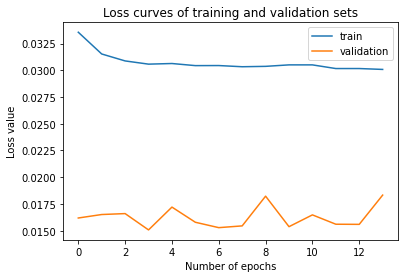

In [ ]:
model_run(Bengaluru_air_met_df,24,Best_BiLSTM_model_saved,'Bengaluru')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [ ]:
BLR_BiLSTM_model = keras.Sequential()
BLR_BiLSTM_model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(24, 21))))
BLR_BiLSTM_model.add(layers.Dropout(0.1))
BLR_BiLSTM_model.add(layers.Dense(1))
BLR_BiLSTM_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

The Best model is now being checked for Bengaluru city...
Epoch 1/100
160/160 [==============================] - 18s 82ms/step - loss: 0.0796 - val_loss: 0.0166
Epoch 2/100
160/160 [==============================] - 13s 83ms/step - loss: 0.0330 - val_loss: 0.0167
Epoch 3/100
160/160 [==============================] - 13s 84ms/step - loss: 0.0317 - val_loss: 0.0155
Epoch 4/100
160/160 [==============================] - 13s 81ms/step - loss: 0.0311 - val_loss: 0.0162
Epoch 5/100
160/160 [==============================] - 13s 83ms/step - loss: 0.0313 - val_loss: 0.0160
Epoch 6/100
160/160 [==============================] - 14s 86ms/step - loss: 0.0308 - val_loss: 0.0152
Epoch 7/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0307 - val_loss: 0.0153
Epoch 8/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0308 - val_loss: 0.0156
Epoch 9/100
160/160 [==============================] - 14s 86ms/step - loss: 0.0307 - val_loss: 0.0171
Epoch 10/100
16

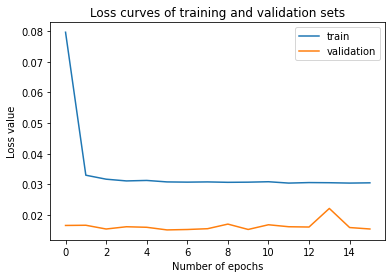

In [ ]:
model_run(Bengaluru_air_met_df,24,BLR_BiLSTM_model,'Bengaluru')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Hyderabad city...
Epoch 1/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0259 - val_loss: 0.0062
Epoch 2/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0251 - val_loss: 0.0072
Epoch 3/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0249 - val_loss: 0.0076
Epoch 4/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0246 - val_loss: 0.0063
Epoch 5/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0246 - val_loss: 0.0068
Epoch 6/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0244 - val_loss: 0.0065
Epoch 7/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0243 - val_loss: 0.0062
Epoch 8/100
160/160 [==============================] - 15s 91ms/step - loss: 0.0245 - val_loss: 0.0062
Epoch 9/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0244 - val_loss: 0.0068
Epoch 10/100
16

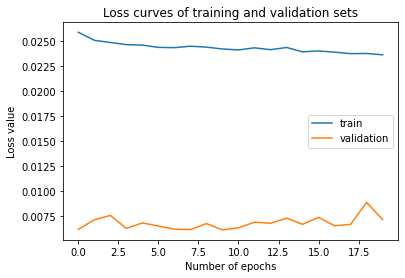

In [ ]:
model_run(Hyderabad_air_met_df,24,Best_BiLSTM_model_saved,'Hyderabad')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [ ]:
HYD_BiLSTM_model = keras.Sequential()
HYD_BiLSTM_model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(24, 21))))
HYD_BiLSTM_model.add(layers.Dropout(0.1))
HYD_BiLSTM_model.add(layers.Dense(1))
HYD_BiLSTM_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

The Best model is now being checked for Hyderabad city...
Epoch 1/100
160/160 [==============================] - 20s 97ms/step - loss: 0.0656 - val_loss: 0.0087
Epoch 2/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0286 - val_loss: 0.0100
Epoch 3/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0264 - val_loss: 0.0081
Epoch 4/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0261 - val_loss: 0.0069
Epoch 5/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0256 - val_loss: 0.0070
Epoch 6/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0253 - val_loss: 0.0069
Epoch 7/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0253 - val_loss: 0.0065
Epoch 8/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0255 - val_loss: 0.0068
Epoch 9/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0250 - val_loss: 0.0063
Epoch 10/100
16

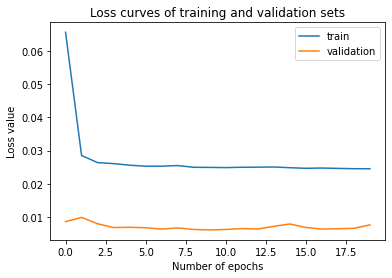

In [ ]:
model_run(Hyderabad_air_met_df,24,HYD_BiLSTM_model,'Hyderabad')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Jaipur city...
Epoch 1/100
82/82 [==============================] - 6s 77ms/step - loss: 0.0190 - val_loss: 0.0105
Epoch 2/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0181 - val_loss: 0.0114
Epoch 3/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0179 - val_loss: 0.0095
Epoch 4/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0178 - val_loss: 0.0097
Epoch 5/100
82/82 [==============================] - 6s 75ms/step - loss: 0.0174 - val_loss: 0.0093
Epoch 6/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0175 - val_loss: 0.0093
Epoch 7/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0171 - val_loss: 0.0095
Epoch 8/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0172 - val_loss: 0.0097
Epoch 9/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0170 - val_loss: 0.0095
Epoch 10/100
82/82 [=========================

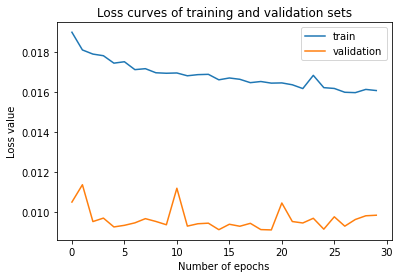

In [ ]:
model_run(Jaipur_air_met_df,24,Best_BiLSTM_model_saved,'Jaipur')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [ ]:
JPR_BiLSTM_model = keras.Sequential()
JPR_BiLSTM_model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(24, 21))))
JPR_BiLSTM_model.add(layers.Dropout(0.1))
JPR_BiLSTM_model.add(layers.Dense(1))
JPR_BiLSTM_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

The Best model is now being checked for Jaipur city...
Epoch 1/100
82/82 [==============================] - 11s 87ms/step - loss: 0.0861 - val_loss: 0.0194
Epoch 2/100
82/82 [==============================] - 6s 77ms/step - loss: 0.0239 - val_loss: 0.0155
Epoch 3/100
82/82 [==============================] - 6s 78ms/step - loss: 0.0215 - val_loss: 0.0110
Epoch 4/100
82/82 [==============================] - 6s 78ms/step - loss: 0.0194 - val_loss: 0.0112
Epoch 5/100
82/82 [==============================] - 6s 78ms/step - loss: 0.0199 - val_loss: 0.0130
Epoch 6/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0187 - val_loss: 0.0101
Epoch 7/100
82/82 [==============================] - 6s 76ms/step - loss: 0.0186 - val_loss: 0.0095
Epoch 8/100
82/82 [==============================] - 6s 77ms/step - loss: 0.0185 - val_loss: 0.0109
Epoch 9/100
82/82 [==============================] - 6s 77ms/step - loss: 0.0183 - val_loss: 0.0095
Epoch 10/100
82/82 [========================

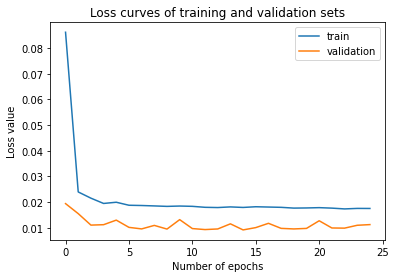

In [ ]:
model_run(Jaipur_air_met_df,24,JPR_BiLSTM_model,'Jaipur')

Training, testing and evaluation of saved best model with transfer learning for different city.

The Best model is now being checked for Mumbai city...
Epoch 1/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0503 - val_loss: 0.0145
Epoch 2/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0498 - val_loss: 0.0166
Epoch 3/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0493 - val_loss: 0.0177
Epoch 4/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0494 - val_loss: 0.0176
Epoch 5/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0493 - val_loss: 0.0187
Epoch 6/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0491 - val_loss: 0.0188
Epoch 7/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0492 - val_loss: 0.0169
Epoch 8/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0489 - val_loss: 0.0150
Epoch 9/100
160/160 [==============================] - 12s 77ms/step - loss: 0.0486 - val_loss: 0.0166
Epoch 10/100
160/1

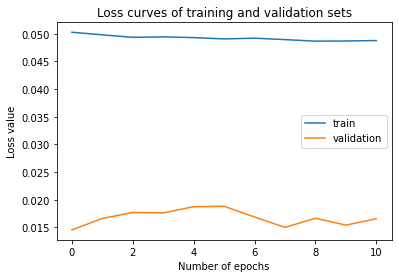

In [ ]:
model_run(Mumbai_air_met_df,24,Best_BiLSTM_model_saved,'Mumbai')

Training, testing and evaluation of best model without transfer learning for same city as above.

**NOTE:** Before executing the below two lines, the code that loads dataframes for other cities has to be rerun to avoid any errors.

In [ ]:
BOM_BiLSTM_model = keras.Sequential()
BOM_BiLSTM_model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(24, 21))))
BOM_BiLSTM_model.add(layers.Dropout(0.1))
BOM_BiLSTM_model.add(layers.Dense(1))
BOM_BiLSTM_model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=tfa.optimizers.AdamW(weight_decay=0.0001, learning_rate=0.01))

The Best model is now being checked for Mumbai city...
Epoch 1/100
160/160 [==============================] - 18s 82ms/step - loss: 0.0876 - val_loss: 0.0226
Epoch 2/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0511 - val_loss: 0.0187
Epoch 3/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0508 - val_loss: 0.0248
Epoch 4/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0507 - val_loss: 0.0155
Epoch 5/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0506 - val_loss: 0.0219
Epoch 6/100
160/160 [==============================] - 14s 90ms/step - loss: 0.0504 - val_loss: 0.0159
Epoch 7/100
160/160 [==============================] - 12s 76ms/step - loss: 0.0500 - val_loss: 0.0154
Epoch 8/100
160/160 [==============================] - 12s 78ms/step - loss: 0.0501 - val_loss: 0.0168
Epoch 9/100
160/160 [==============================] - 13s 78ms/step - loss: 0.0501 - val_loss: 0.0156
Epoch 10/100
160/1

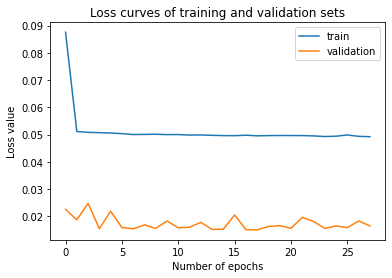

In [ ]:
model_run(Mumbai_air_met_df,24,BOM_BiLSTM_model,'Mumbai')